In [ ]:
# --- Setup: Install Packages ---
print("Installing required packages...")
%pip install -q git+https://github.com/facebookresearch/segment-anything.git
%pip install -q opencv-python pycocotools matplotlib onnxruntime onnx kagglehub

# --- Imports ---
import os, gc, time, traceback
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import tensorflow as tf
import torch
from segment_anything import sam_model_registry, SamPredictor
import kagglehub

# --- Google Drive Mount ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- Memory Optimization ---
def optimize_memory():
    tf.keras.backend.clear_session()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


Installing required packages...
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# --- Dataset Setup ---
try:
    path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
except:
    path = "./face-mask-detection"

ANNOTATION_PATH = next((p for p in [
    f'{path}/annotations',
    '/content/drive/MyDrive/face-mask-detection/versions/1/annotations',
    './annotations'
] if os.path.exists(p)), None)

IMAGE_PATH = next((p for p in [
    f'{path}/images',
    '/content/drive/MyDrive/face-mask-detection/versions/1/images',
    './images'
] if os.path.exists(p)), None)

assert ANNOTATION_PATH and IMAGE_PATH, "Annotation or image directory not found."

# --- Parse XML Annotations ---
def parse_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        annotations = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            coords = {k: int(bbox.find(k).text) for k in ['xmin', 'ymin', 'xmax', 'ymax']}
            annotations.append({
                'filename': root.find('filename').text,
                'label': label,
                'bbox': coords
            })
        return annotations
    except Exception as e:
        print(f"[!] Failed parsing {xml_file}: {e}")
        return []

# --- Load DataFrame from XMLs ---
xml_files = [os.path.join(ANNOTATION_PATH, f) for f in os.listdir(ANNOTATION_PATH) if f.endswith('.xml')]
data = [item for xml in xml_files[:10] for item in parse_xml(xml)]
df = pd.DataFrame(data)

# --- Visualize Annotation ---
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)
    if image is None:
        print(f"[!] Failed to load {image_path}")
        return
    for ann in annotations:
        box = ann['bbox']
        cv2.rectangle(image, (box['xmin'], box['ymin']), (box['xmax'], box['ymax']), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# --- Download SAM Checkpoint ---
!mkdir -p sam_checkpoints
!wget -q -P sam_checkpoints https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# --- Load SAM Model ---
sam = sam_model_registry["vit_b"](checkpoint="sam_checkpoints/sam_vit_b_01ec64.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device)
predictor = SamPredictor(sam)



100%|██████████| 398M/398M [00:03<00:00, 112MB/s]

Extracting files...


In [ ]:
# --- Expand Bounding Box ---
def expand_bbox(bbox, shape, ratio=0.5):
    h, w = shape[:2]
    bw, bh = bbox['xmax'] - bbox['xmin'], bbox['ymax'] - bbox['ymin']
    xp = int(bw * ratio)
    yp = int(bh * ratio)
    return np.array([
        max(0, bbox['xmin'] - xp),
        max(0, bbox['ymin'] - yp),
        min(w, bbox['xmax'] + xp),
        min(h, bbox['ymax'] + yp * 2)
    ])



In [ ]:
# --- SAM Segmentation ---
def process_image_with_sam(image_path, bbox):
    image = cv2.imread(image_path)
    if image is None: return False, None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)
    expanded_box = expand_bbox(bbox, image.shape)
    masks, scores, _ = predictor.predict(box=expanded_box, multimask_output=True)
    best = np.argmax(scores)
    plt.figure(figsize=(12, 4))
    for i, m in enumerate([masks[best], ~masks[best]]):
        plt.subplot(1, 2, i+1)
        plt.imshow(image_rgb)
        plt.imshow(m, alpha=0.6)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    return True, masks[best]




Processing: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss541.png


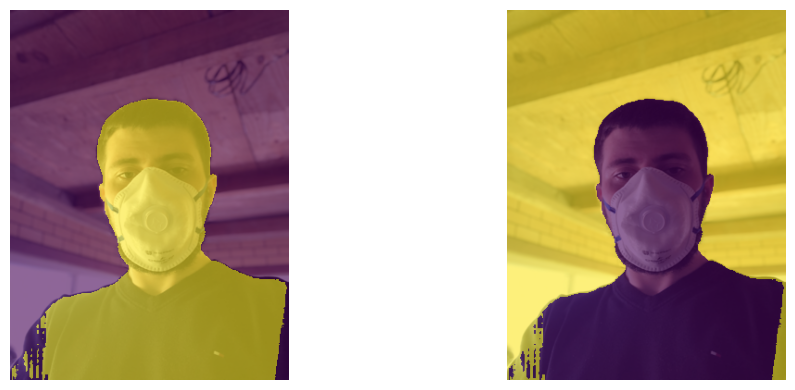


Processing: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss727.png


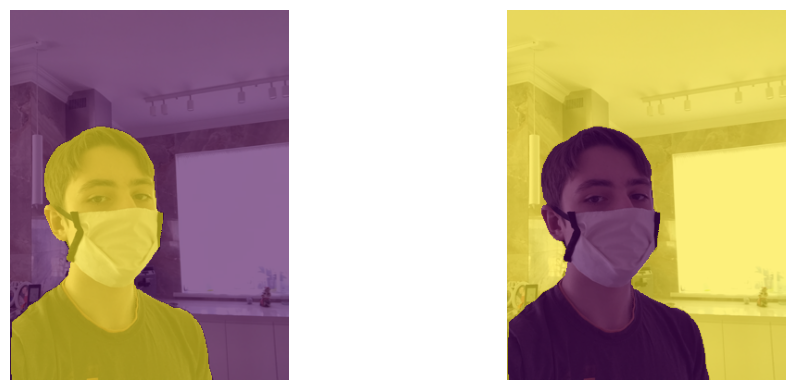


Processing: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss366.png


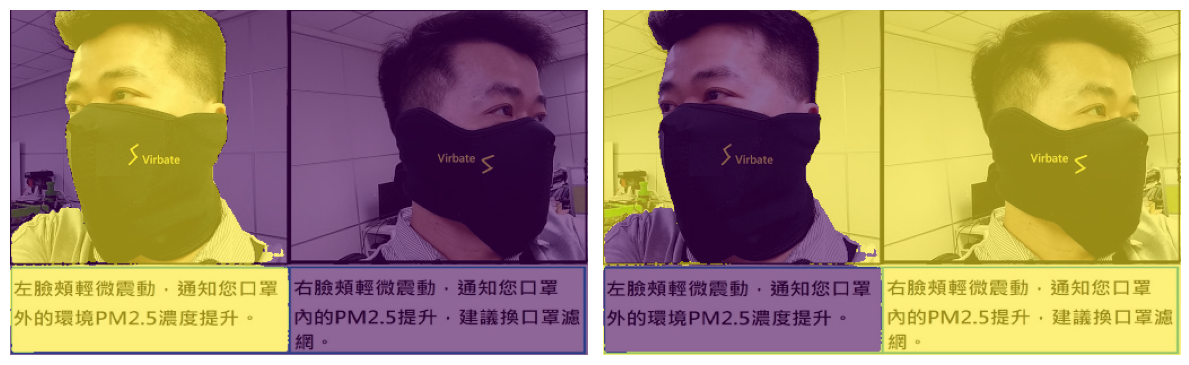

In [ ]:
# --- Run Sample Processing ---
for _, row in df.head(3).iterrows():
    img_path = os.path.join(IMAGE_PATH, row['filename'])
    print(f"\nProcessing: {img_path}")
    process_image_with_sam(img_path, row['bbox'])
    optimize_memory()
